In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
# Importing the training and testing sets
%run "./Data Splitting.ipynb"

In [3]:
grouped_df = grouped_df[["REVENUE","REPORT_DATE","IS_CODE6_ENABLED"]]

# We need to have the IS_CODE6_ENABLED as 0 and 1 for it to work with the tensors
grouped_df['IS_CODE6_ENABLED'] = grouped_df['IS_CODE6_ENABLED'].astype(float)
grouped_df

,REVENUE,REPORT_DATE,IS_CODE6_ENABLED
0,51542876.0,2022-01-01,1.0
1,50323396.0,2022-01-02,1.0
2,40495420.0,2022-01-03,0.0
3,38233080.0,2022-01-04,0.0
4,38971034.0,2022-01-05,0.0
...,...,...,...
724,45294984.0,2023-12-27,1.0
725,46355479.0,2023-12-28,1.0
726,46790381.0,2023-12-29,1.0
727,50994081.0,2023-12-30,1.0


## Preparing the data for the training

In [4]:
# Adding the lag
for i in range(1, 31):
    grouped_df[f'REVENUE_LAG_{i}'] = grouped_df['REVENUE'].shift(i)
    grouped_df[f'IS_CODE6_ENABLED_{i}'] = grouped_df['IS_CODE6_ENABLED'].shift(i).astype(float)
grouped_df.dropna(inplace=True); grouped_df.reset_index(drop=True,inplace=True)
grouped_df

,REVENUE,REPORT_DATE,IS_CODE6_ENABLED,REVENUE_LAG_1,IS_CODE6_ENABLED_1,REVENUE_LAG_2,IS_CODE6_ENABLED_2,REVENUE_LAG_3,IS_CODE6_ENABLED_3,REVENUE_LAG_4,...,REVENUE_LAG_26,IS_CODE6_ENABLED_26,REVENUE_LAG_27,IS_CODE6_ENABLED_27,REVENUE_LAG_28,IS_CODE6_ENABLED_28,REVENUE_LAG_29,IS_CODE6_ENABLED_29,REVENUE_LAG_30,IS_CODE6_ENABLED_30
0,52844086.0,2022-01-31,1.0,53163720.0,1.0,55202179.0,1.0,49976530.0,1.0,49821942.0,...,38971034.0,0.0,38233080.0,0.0,40495420.0,0.0,50323396.0,1.0,51542876.0,1.0
1,50827217.0,2022-02-01,1.0,52844086.0,1.0,53163720.0,1.0,55202179.0,1.0,49976530.0,...,39868483.0,0.0,38971034.0,0.0,38233080.0,0.0,40495420.0,0.0,50323396.0,1.0
2,47161932.0,2022-02-02,1.0,50827217.0,1.0,52844086.0,1.0,53163720.0,1.0,55202179.0,...,38914818.0,0.0,39868483.0,0.0,38971034.0,0.0,38233080.0,0.0,40495420.0,0.0
3,47290207.0,2022-02-03,1.0,47161932.0,1.0,50827217.0,1.0,52844086.0,1.0,53163720.0,...,42112136.0,0.0,38914818.0,0.0,39868483.0,0.0,38971034.0,0.0,38233080.0,0.0
4,45669072.0,2022-02-04,1.0,47290207.0,1.0,47161932.0,1.0,50827217.0,1.0,52844086.0,...,40027863.0,0.0,42112136.0,0.0,38914818.0,0.0,39868483.0,0.0,38971034.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
694,45294984.0,2023-12-27,1.0,45645742.0,1.0,46914493.0,1.0,42341461.0,1.0,46480578.0,...,49363970.0,0.0,51797874.0,0.0,50908551.0,0.0,49815137.0,0.0,50485043.0,0.0
695,46355479.0,2023-12-28,1.0,45294984.0,1.0,45645742.0,1.0,46914493.0,1.0,42341461.0,...,186547029.0,1.0,49363970.0,0.0,51797874.0,0.0,50908551.0,0.0,49815137.0,0.0
696,46790381.0,2023-12-29,1.0,46355479.0,1.0,45294984.0,1.0,45645742.0,1.0,46914493.0,...,92529688.0,1.0,186547029.0,1.0,49363970.0,0.0,51797874.0,0.0,50908551.0,0.0
697,50994081.0,2023-12-30,1.0,46790381.0,1.0,46355479.0,1.0,45294984.0,1.0,45645742.0,...,85347487.0,1.0,92529688.0,1.0,186547029.0,1.0,49363970.0,0.0,51797874.0,0.0


In [5]:
# Splitting the new lagged dataFrame for training and testing
group_split_value = int(len(grouped_df)*0.8)

df_train = grouped_df.iloc[:group_split_value]
df_test = grouped_df.iloc[group_split_value:]

X_train = df_train.drop(columns=["REPORT_DATE","REVENUE"]).values
y_train = df_train["REVENUE"].values.reshape(-1, 1)

X_test = df_test.drop(columns=["REPORT_DATE","REVENUE"]).values
y_test = df_test["REVENUE"].values.reshape(-1, 1)

In [6]:
# Scaling the data for the lstm to converge quickly
from sklearn.preprocessing import MinMaxScaler

# Initialize the scaler for X
scaler_X = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Initialize the scaler for y which is not necessary
scaler_y = MinMaxScaler(feature_range=(0, 1))
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

## LSTM

In [7]:
# importing all necessary tensorflow libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam

In [8]:
# Reshaping the data to work with the tensors (3D)
X_train_reshaped = X_train_scaled.reshape((X_train.shape[0], 1, 61))
X_test_reshaped = X_test_scaled.reshape((X_test.shape[0], 1, 61))

In [102]:
# Defining the LSTM model
model = Sequential()
model.add(Input(shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
model.add(LSTM(1000, return_sequences=True))  
model.add(Dropout(0.1))  
model.add(LSTM(300, return_sequences=True)) 
model.add(Dropout(0.1)) 
model.add(LSTM(300, return_sequences=True)) 
model.add(Dropout(0.2))  
model.add(LSTM(300, return_sequences=True))  
model.add(Dropout(0.2))  
model.add(LSTM(300, return_sequences=True)) 
model.add(Dropout(0.1)) 
model.add(LSTM(300, return_sequences=True)) 
model.add(Dropout(0.15))
model.add(LSTM(350, return_sequences=False)) 
model.add(Dense(1))
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_31 (LSTM)                       │ (None, 1, 1000)             │       4,248,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 1, 1000)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_32 (LSTM)                       │ (None, 1, 300)              │       1,561,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_26 (Dropout)                 │ (None, 1, 300)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_33 (LSTM)                       │ (None, 1, 300)              │         721,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_27 (Dropout)                 │ (None, 1, 300)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_34 (LSTM)                       │ (None, 1, 300)              │         721,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_28 (Dropout)                 │ (None, 1, 300)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_35 (LSTM)                       │ (None, 1, 300)              │         721,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_29 (Dropout)                 │ (None, 1, 300)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_36 (LSTM)                       │ (None, 1, 300)              │         721,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_30 (Dropout)                 │ (None, 1, 300)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_37 (LSTM)                       │ (None, 350)                 │         911,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             351 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,605,751 (36.64 MB)

 Trainable params: 9,605,751 (36.64 MB)

 Non-trainable params: 0 (0.00 B)

In [103]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_absolute_error')

# Fit the model
history = model.fit(X_train_reshaped, y_train_scaled, epochs=200, batch_size=30, validation_data=(X_test_reshaped, y_test_scaled))

Epoch 1/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 14s 220ms/step - loss: 0.1746 - val_loss: 0.0490
Epoch 2/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - loss: 0.0707 - val_loss: 0.0486
Epoch 3/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - loss: 0.0631 - val_loss: 0.0491
Epoch 4/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - loss: 0.0625 - val_loss: 0.0525
Epoch 5/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - loss: 0.0637 - val_loss: 0.0411
Epoch 6/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - loss: 0.0547 - val_loss: 0.0482
Epoch 7/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 154ms/step - loss: 0.0511 - val_loss: 0.0462
Epoch 8/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - loss: 0.0461 - val_loss: 0.0403
Epoch 9/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - loss: 0.0428 - val_loss: 0.0588
Epoch 10/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - loss: 0.0489 - val_loss: 0.0500
Epoch 11/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - loss: 0.0458 - val_loss: 0.0309
Epoch 12/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - loss: 0.0284 - val_loss: 0.0191
Epoch 69/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - loss: 0.0243 - val_loss: 0.0209
Epoch 70/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - loss: 0.0232 - val_loss: 0.0201
Epoch 71/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - loss: 0.0281 - val_loss: 0.0212
Epoch 72/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - loss: 0.0250 - val_loss: 0.0201
Epoch 73/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - loss: 0.0239 - val_loss: 0.0321
Epoch 74/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - loss: 0.0310 - val_loss: 0.0395
Epoch 75/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - loss: 0.0248 - val_loss: 0.0206
Epoch 76/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - loss: 0.0266 - val_loss: 0.0210
Epoch 77/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - loss: 0.0280 - val_loss: 0.0198
Epoch 78/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - loss: 0.0267 - val_loss: 0.0226
Epoch 79/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 14

Epoch 135/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - loss: 0.0225 - val_loss: 0.0201
Epoch 136/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - loss: 0.0209 - val_loss: 0.0225
Epoch 137/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - loss: 0.0217 - val_loss: 0.0177
Epoch 138/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 154ms/step - loss: 0.0262 - val_loss: 0.0263
Epoch 139/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - loss: 0.0225 - val_loss: 0.0183
Epoch 140/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - loss: 0.0206 - val_loss: 0.0178
Epoch 141/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 157ms/step - loss: 0.0223 - val_loss: 0.0182
Epoch 142/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - loss: 0.0240 - val_loss: 0.0176
Epoch 143/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - loss: 0.0223 - val_loss: 0.0257
Epoch 144/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - loss: 0.0235 - val_loss: 0.0190
Epoch 145/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 164ms/step - loss: 0.0211 - val_loss: 0.0183
Epoch 146/200
19/19 ━

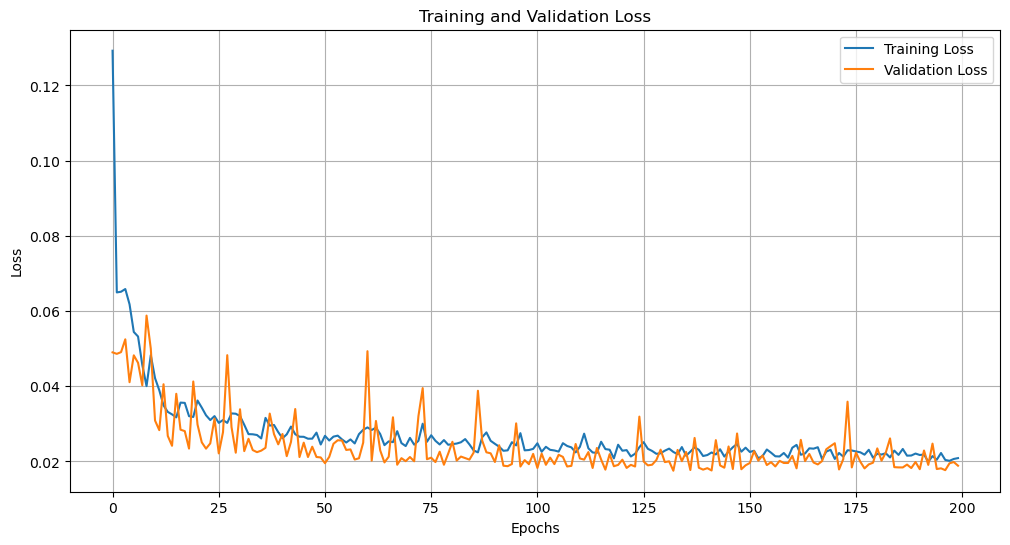

In [104]:
# Checking if there is a overfitting

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

plt.figure(figsize=(12, 6))
plt.plot(loss_values, label='Training Loss')
plt.plot(val_loss_values, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [112]:
# Making the dataframe

y_pred = scaler_y.inverse_transform(model.predict(X_test_reshaped))
abs_diff = np.abs((y_pred.reshape(-1) - y_test.reshape(-1)))

data = pd.DataFrame({
    "test":y_test.reshape(-1),
    "pred":y_pred.reshape(-1),
    "diff_val_by_million":np.ceil(abs_diff/1e6),
    "diff_percentage": abs_diff / y_test.reshape(-1) * 100
})

data

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


,test,pred,diff_val_by_million,diff_percentage
0,67486495.0,62135704.0,5.350791,7.928684
1,71299590.0,63880176.0,7.419414,10.405970
2,72975580.0,69722800.0,3.252780,4.457354
3,74648393.0,71086240.0,3.562153,4.771908
4,71091750.0,70250512.0,0.841238,1.183313
...,...,...,...,...
135,45294984.0,45166316.0,0.128668,0.284067
136,46355479.0,46421936.0,0.066457,0.143364
137,46790381.0,41083056.0,5.707325,12.197646
138,50994081.0,52611480.0,1.617399,3.171739


count    140.000000
mean       4.656992
std        4.697745
min        0.105684
25%        1.498163
50%        3.690454
75%        5.852570
max       33.850457
Name: diff_percentage, dtype: float64


<Axes: >

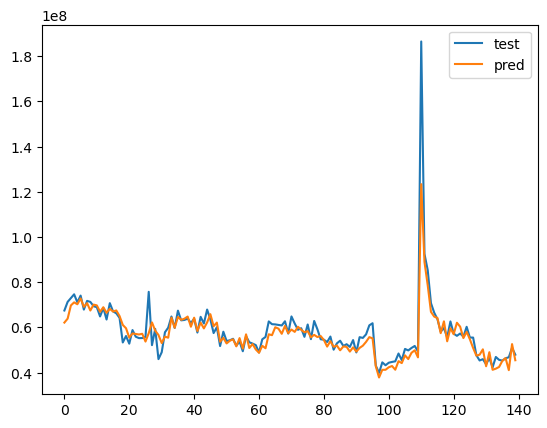

In [106]:
print(data["diff_percentage"].describe())
data[["test","pred"]].plot()

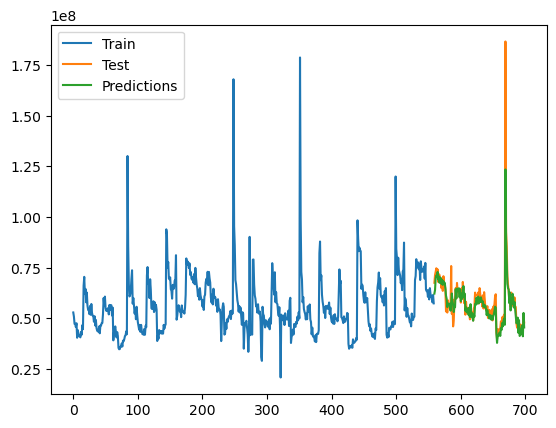

In [107]:
# Creating nan_arr to be able to shift the plots of the test and prediction
nan_arr = np.empty((group_split_value,1))
nan_arr[:]=np.nan

shifted_tests = np.concatenate((nan_arr, y_test), axis=0)
shifted_preds = np.concatenate((nan_arr, data["pred"].values.reshape(-1,1)), axis=0)

plt.figure(figsize=(12, 6))
plt.plot(y_train,label="Train")
plt.plot(shifted_tests,label="Test")
plt.plot(shifted_preds,label="Predictions")
plt.legend()